# Time Series Forecasting with Dart ensamble of models

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional
from darts import models, backtesting
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from custom_code import sumape
from statsmodels.tsa.seasonal import seasonal_decompose 

%matplotlib inline

In [12]:
pd.plotting.register_matplotlib_converters()


# Dart

## Train one model for each entity

In [13]:
df_all = pd.read_csv("efecty_drawdowns.csv", dtype={"y":float, "entity_id":int, "ds":str}, index_col=0)
df_all["ds"] = pd.to_datetime(df_all["ds"], format='%Y-%m-%d')
df_all.head()

,ds,y,entity_id
0,2019-02-05,3383730.0,995152
1,2019-02-05,988994.0,992133
2,2019-02-05,597150.0,995388
3,2019-02-05,50000.0,902343
4,2019-02-05,1426410.0,993733


In [14]:
len(df_all.entity_id.unique())

254

## Fill missing values
TimeSeries add missing date with nan values, and you have to fillna values with `auto_fillna` function

In [15]:
def create_time_series(df:pd.DataFrame) -> TimeSeries:
    """
    Create a time series filling missing dates and filling the values of those mising dates.
    and then split the entire ts in val and train.

    Parameters
    ----------
    df
        pandas dataframe.
    
    Returns
    -------
    TimeSeries
        The TimeSeries filled.
    """
    series = TimeSeries.from_dataframe(df, "ds", "y" )
    series = missing_values.auto_fillna(series, method="slinear")

    return series 

In [16]:
def train_ensamble_model(
    series:TimeSeries , 
    date_division:str,
    pred_length: int,
    train_n_points: int) ->  TimeSeries :
    """
    Train a TCN Model for the given time series and hyperparameters.
    
    Parameters
    ----------
    series
        TimeSeries to train with
    date_division
        A string of dateTime for split the series.
    pred_length
        length of the prediction
    train_n_points
        The number of most recent points from training (features and target) time series 
        that will be used to train the regression model.

    Returns
    -------
    TimeSeries
        A time series containing the forecast values
    """
    models_naive = [models.NaiveSeasonal(7), models.NaiveSeasonal(14), models.NaiveDrift()]
    
    model_predictions = [backtesting.backtest_forecasting(series, m, pd.Timestamp(date_division), fcast_horizon_n=pred_length*2 , verbose=False) for m in models_naive]

    regr_model = models.StandardRegressionModel(train_n_points=train_n_points)
    
    regr_date_division = '20200115'	

    series_target = series.slice_intersect(model_predictions[0])

    ensemble_pred = backtesting.backtest_regression(model_predictions, 
                                                    series_target, 
                                                    regr_model,pd.Timestamp(regr_date_division),                                                      fcast_horizon_n=pred_length, 
                                                    verbose=False
                                                    )
    return ensemble_pred

In [17]:
entities = df_all.entity_id.unique()
error_dict_3 = {}
date_division = "20200101"
train_n_points = 16
pred_length = 3

for entity in entities:
    df_entity = df_all[df_all.entity_id == entity]
    if len(df_entity) > 370 :
        print(entity)
        try :
            series = create_time_series(df_entity)
            ensemble_pred = train_ensamble_model(series , date_division, pred_length, train_n_points)
            error = sumape(series, ensemble_pred)
            print(entity, error)
            error_dict_3[entity] = error
        except:
            print("error in entity: " + str(entity))
            pass

992133
992133 33.97976369671319
992807
[2020-07-23 13:18:37,059] ERROR | darts.timeseries | ValueError: Could not infer explicit frequency. Observed frequencies: {'D', '2D'}. Is Series too short (n=2)?
error in entity: 992807
997611
[2020-07-23 13:18:41,896] ERROR | main_logger | ValueError: The actual series must be strictly positive to compute the SuMAPE.
[2020-07-23 13:18:41,896] ERROR | main_logger | ValueError: The actual series must be strictly positive to compute the SuMAPE.
[2020-07-23 13:18:41,896] ERROR | main_logger | ValueError: The actual series must be strictly positive to compute the SuMAPE.
[2020-07-23 13:18:41,896] ERROR | main_logger | ValueError: The actual series must be strictly positive to compute the SuMAPE.
error in entity: 997611
992440
[2020-07-23 13:18:47,069] ERROR | main_logger | ValueError: The actual series must be strictly positive to compute the SuMAPE.
[2020-07-23 13:18:47,069] ERROR | main_logger | ValueError: The actual series must be strictly positi

In [18]:
df_entity = df_all[df_all.entity_id == 992521]
series = create_time_series(df_entity)
ensemble_pred = train_ensamble_model(series , date_division, pred_length, train_n_points)
error = sumape(series, ensemble_pred)
print(entity, error)
error_dict_3[entity] = error

907637 38.42358894427063


In [19]:
error_dict_3

{992133: 33.97976369671319,
 904458: 31.331211493510796,
 995567: 35.18898374867155,
 10434: 31.23565305916007,
 999100: 41.7898530382269,
 991476: 49.2408362078992,
 70015: 33.07524221466495,
 995363: 36.242297909083085,
 992521: 38.42358894427063,
 904095: 57.81684301022608,
 18001: 26.434744955037853,
 996986: 40.46639203686033,
 46001: 26.213590022586132,
 996490: 33.447643056057075,
 902247: 66.1594831522765,
 903545: 68.10445923641173,
 800263: 52.38797472093275,
 904236: 25.062795257578607,
 800244: 38.796381770381885,
 991947: 55.59328673135291,
 900333: 30.510499589352918,
 992032: 21.781948411967882,
 904446: 34.03833844020664,
 900057: 30.842464519593737,
 903787: 47.50989218190092,
 904872: 37.0321084838166,
 907637: 38.42358894427063}

Text(0.5, 1.0, 'Average SuMAPE Error TCN: 39.30%')

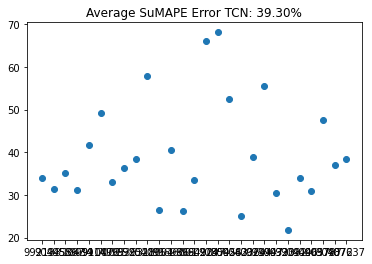

In [20]:
x = [*map(str,error_dict_3.keys())]
y = error_dict_3.values()
plt.scatter(x,y )
plt.title('Average SuMAPE Error TCN: {:.2f}%'.format(np.mean(list(y))))